<a href="https://colab.research.google.com/github/santiagonajera/LOCALIZACION-OPTIMA-DE-CENTROS-DE-DISTRIBUCION-MEDIANTE-MACHINE-LEARNING/blob/main/Clusters_21nov25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# URL del archivo de datos
url = "https://raw.githubusercontent.com/santiagonajera/LOCALIZACION-OPTIMA-DE-CENTROS-DE-DISTRIBUCION-MEDIANTE-MACHINE-LEARNING/main/coordenadas_peru_5000_puntos.txt"

# --- 1. Cargar y Preprocesar los Datos ---
print("--- 1. Cargando y Preprocesando Datos ---")

# Los datos son separados por comas, pero el decimal es coma (,)
# Esto requiere un paso adicional para reemplazar la coma decimal por punto (.)
df = pd.read_csv(url, sep=',')

# Identificar columnas numéricas que tienen la coma decimal (,)
# Basado en la imagen, son 'LATITUD' y 'LONGITUD'
cols_to_clean = ['LATITUD', 'LONGITUD', 'DEMANDA_P.POBLACION', 'DENSIDAD_DEMANDA']

for col in cols_to_clean:
    # Reemplazar la coma por punto y convertir a float
    if col in df.columns:
        df[col] = df[col].astype(str).str.replace(',', '.', regex=False)
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Seleccionar solo las características para el clustering (Latitud y Longitud)
# Estos son los datos X que el modelo utilizará para la agrupación.
X = df[['LATITUD', 'LONGITUD']].copy()

# Opcional: Estandarizar las coordenadas. Aunque para lat/lon no siempre es estrictamente necesario,
# ayuda a K-Means a converger mejor al tratar todas las dimensiones por igual.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Dimensiones de los datos para clustering: {X_scaled.shape}\n")


# --- 2. Determinar el Número Óptimo de Clústeres (K) ---
# Exploraremos un rango de K de 2 a 10
K_RANGE = range(2, 11)
wcss = [] # Suma de cuadrados dentro del clúster (Inertia) para el Método del Codo
silhouette_scores = [] # Coeficientes de Silueta para el Método de la Silueta

print("--- 2. Calculando Métricas para diferentes K (2 a 10) ---")
for k in K_RANGE:
    # Inicialización con k-means++ para mejorar la convergencia
    kmeans_model = KMeans(n_clusters=k, init='k-means++', n_init='auto', random_state=42)
    kmeans_model.fit(X_scaled)

    # 2.1 Método del Codo: Registrar la inercia (WCSS)
    wcss.append(kmeans_model.inertia_)

    # 2.2 Coeficiente de Silueta: Calcular y registrar el score
    score = silhouette_score(X_scaled, kmeans_model.labels_)
    silhouette_scores.append(score)
    print(f"K={k}: WCSS={wcss[-1]:.2f}, Silhouette Score={score:.4f}")


# --- 3. Visualización y Selección de K ---

# 3.1 Gráfico del Método del Codo
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(K_RANGE, wcss, marker='o', linestyle='--')
plt.title('Método del Codo')
plt.xlabel('Número de Clústeres (K)')
plt.ylabel('WCSS (Inercia)')
plt.grid(True)

# 3.2 Gráfico del Coeficiente de Silueta
plt.subplot(1, 2, 2)
plt.plot(K_RANGE, silhouette_scores, marker='o', linestyle='--')
plt.title('Coeficiente de Silueta')
plt.xlabel('Número de Clústeres (K)')
plt.ylabel('Silueta Promedio')
plt.grid(True)

plt.tight_layout()
plt.show()

# Determinar el K óptimo basado en la Silueta (el valor más alto)
optimal_k_silhouette = K_RANGE[np.argmax(silhouette_scores)]
print(f"\nNúmero óptimo de clústeres (K) según el Coeficiente de Silueta: {optimal_k_silhouette}")

# *Observación: El valor óptimo de K según el Método del Codo se debe determinar visualmente,
# buscando el punto donde la curva WCSS se "dobla" o se suaviza.*


# --- 4. Ajustar K-Means con el K Seleccionado (Usando Silueta para ejemplo) ---

# Usa el valor óptimo_k_silhouette o ajusta manualmente el K después de ver los gráficos
FINAL_K = optimal_k_silhouette
print(f"\n--- 4. Ajustando el modelo K-Means con K={FINAL_K} ---")

kmeans_final = KMeans(n_clusters=FINAL_K, init='k-means++', n_init='auto', random_state=42)
kmeans_final.fit(X_scaled)

# Asignar las etiquetas de clústeres al DataFrame original
df['Cluster'] = kmeans_final.labels_

# Obtener los centroides (en datos escalados)
centroids_scaled = kmeans_final.cluster_centers_

# Deshacer la estandarización para obtener los centroides en Latitud y Longitud originales
# Es importante invertir la transformación para tener las coordenadas reales
centroids = scaler.inverse_transform(centroids_scaled)
centroids_df = pd.DataFrame(centroids, columns=['LATITUD_CENTROIDE', 'LONGITUD_CENTROIDE'])
centroids_df['Cluster'] = range(FINAL_K)

print("\n📍 Ubicaciones de los Centroides (Posibles Centros de Distribución):")
print(centroids_df)


# --- 5. Visualizar los Clústeres y Centroides en el Mapa ---

plt.figure(figsize=(10, 8))
# Trazar todos los puntos de datos, coloreados por clúster
scatter = plt.scatter(df['LONGITUD'], df['LATITUD'], c=df['Cluster'], cmap='viridis', s=20, alpha=0.6)

# Trazar los centroides (Posibles ubicaciones de CD)
plt.scatter(centroids_df['LONGITUD_CENTROIDE'], centroids_df['LATITUD_CENTROIDE'],
            marker='X', s=200, color='red', edgecolor='black', label='Centroides (CD)')

plt.title(f'Agrupamiento K-Means de Puntos de Demanda (K={FINAL_K})')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.legend(handles=scatter.legend_elements()[0] + [plt.Line2D([0], [0], marker='X', color='w', label='Centroides (CD)',
                                                            markerfacecolor='red', markersize=10, markeredgecolor='black')],
           title="Clústeres")
plt.grid(True)
plt.show()

--- 1. Cargando y Preprocesando Datos ---


KeyError: "None of [Index(['LATITUD', 'LONGITUD'], dtype='object')] are in the [columns]"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import seaborn as sns # Añadimos seaborn para visualización mejorada

# URL del archivo de datos
url = "https://raw.githubusercontent.com/santiagonajera/LOCALIZACION-OPTIMA-DE-CENTROS-DE-DISTRIBUCION-MEDIANTE-MACHINE-LEARNING/main/coordenadas_peru_5000_puntos.txt"

## --- 1. Cargar y Preprocesar los Datos ---
print("--- 1. Cargando y Preprocesando Datos ---")

# Cargar el archivo, separado por comas
df = pd.read_csv(url, sep=',')

# Paso 1: Limpiar los nombres de las columnas (Eliminar espacios en blanco)
df.columns = df.columns.str.strip()
print("Nombres de columnas después de la limpieza:", df.columns.tolist())

# Paso 2: Limpieza de la coma decimal (,) y conversión a tipo numérico
# Identificar columnas que deberían ser numéricas (incluyendo LATITUD y LONGITUD)
numeric_cols = ['LATITUD', 'LONGITUD', 'DEMANDA_P.POBLACION', 'DENSIDAD_DEMANDA']

for col in numeric_cols:
    if col in df.columns:
        # Reemplazar la coma decimal por punto y forzar la conversión a float
        df[col] = df[col].astype(str).str.replace(',', '.', regex=False)
        # Usamos errors='coerce' para convertir cualquier valor no válido a NaN
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Verificar si hay valores faltantes (NaN) y rellenarlos si es necesario
# Para este caso, vamos a rellenar con la media, asumiendo que es un error de lectura
df.dropna(subset=['LATITUD', 'LONGITUD'], inplace=True)
print(f"Número final de puntos de datos: {len(df)}")

# Seleccionar solo las características para el clustering (Latitud y Longitud)
X = df[['LATITUD', 'LONGITUD']].copy()

# Estandarizar las coordenadas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Dimensiones de los datos para clustering: {X_scaled.shape}\n")

## --- 2. Determinar el Número Óptimo de Clústeres (K) ---
# Exploraremos un rango de K de 2 a 10
K_RANGE = range(2, 11)
wcss = [] # Método del Codo (Inertia)
silhouette_scores = [] # Coeficiente de Silueta

print("--- 2. Calculando Métricas para diferentes K (2 a 10) ---")
for k in K_RANGE:
    # Asegurarse de que el número de clústeres no exceda el número de muestras
    if k >= len(X_scaled):
        print(f"Advertencia: K={k} es demasiado grande. Deteniendo la búsqueda.")
        break

    # Inicialización con k-means++ para mejorar la convergencia
    kmeans_model = KMeans(n_clusters=k, init='k-means++', n_init='auto', random_state=42)
    kmeans_model.fit(X_scaled)

    # Método del Codo: Registrar la inercia (WCSS)
    wcss.append(kmeans_model.inertia_)

    # Coeficiente de Silueta
    score = silhouette_score(X_scaled, kmeans_model.labels_)
    silhouette_scores.append(score)
    print(f"K={k}: WCSS={wcss[-1]:.2f}, Silhouette Score={score:.4f}")

## --- 3. Visualización y Selección de K ---

plt.style.use('ggplot')
plt.figure(figsize=(14, 5))

# 3.1 Gráfico del Método del Codo
plt.subplot(1, 2, 1)
plt.plot(K_RANGE[:len(wcss)], wcss, marker='o', linestyle='--', color='blue')
plt.title('Método del Codo (WCSS)', fontsize=14)
plt.xlabel('Número de Clústeres (K)', fontsize=12)
plt.ylabel('WCSS (Inercia)', fontsize=12)
plt.xticks(K_RANGE[:len(wcss)])


# 3.2 Gráfico del Coeficiente de Silueta
plt.subplot(1, 2, 2)
plt.plot(K_RANGE[:len(silhouette_scores)], silhouette_scores, marker='o', linestyle='--', color='green')
plt.title('Coeficiente de Silueta', fontsize=14)
plt.xlabel('Número de Clústeres (K)', fontsize=12)
plt.ylabel('Silueta Promedio', fontsize=12)
plt.xticks(K_RANGE[:len(silhouette_scores)])


plt.suptitle('Evaluación para la Determinación del Número Óptimo de Clústeres', fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

# Determinar el K óptimo basado en el Coeficiente de Silueta (el valor más alto)
# Este es un buen punto de partida, pero debe confirmarse con el gráfico del codo.
if silhouette_scores:
    optimal_k_silhouette = K_RANGE[np.argmax(silhouette_scores)]
else:
    optimal_k_silhouette = 3 # Valor por defecto si no se pudo calcular

print(f"\nNúmero óptimo de clústeres (K) sugerido por Silueta: {optimal_k_silhouette}")


## --- 4. Ajustar K-Means y Encontrar Ubicaciones (Centroides) ---

# Ajusta FINAL_K si los gráficos sugieren un número diferente al de Silueta
FINAL_K = optimal_k_silhouette
print(f"\n--- 4. Ajustando el modelo K-Means final con K={FINAL_K} ---")

kmeans_final = KMeans(n_clusters=FINAL_K, init='k-means++', n_init='auto', random_state=42)
kmeans_final.fit(X_scaled)

# Asignar las etiquetas de clústeres al DataFrame original
df['Cluster'] = kmeans_final.labels_

# Obtener y desescalar los centroides (ubicaciones finales)
centroids_scaled = kmeans_final.cluster_centers_
centroids = scaler.inverse_transform(centroids_scaled)

centroids_df = pd.DataFrame(centroids, columns=['LATITUD_CENTROIDE', 'LONGITUD_CENTROIDE'])
centroids_df['Cluster'] = [f'CD {i}' for i in range(FINAL_K)]

print("\n📍 Ubicaciones Finales de los Centros de Distribución (Centroides):")
print(centroids_df.set_index('Cluster'))


## --- 5. Visualizar los Clústeres y Centroides ---

plt.figure(figsize=(10, 8))
# Usamos el color 'tab10' y seaborn para una mejor visualización de los clústeres
sns.scatterplot(x='LONGITUD', y='LATITUD', hue='Cluster', data=df,
                palette='tab10', s=20, alpha=0.6, legend=False)

# Trazar los centroides (Posibles ubicaciones de CD)
plt.scatter(centroids_df['LONGITUD_CENTROIDE'], centroids_df['LATITUD_CENTROIDE'],
            marker='X', s=250, color='red', edgecolor='black', linewidth=1.5, label='Centroides (CD)')

plt.title(f'Agrupamiento K-Means de Puntos de Demanda (K={FINAL_K})', fontsize=16)
plt.xlabel('Longitud', fontsize=12)
plt.ylabel('Latitud', fontsize=12)
plt.legend(title='Ubicación', loc='upper right')
plt.grid(True)
plt.show()

--- 1. Cargando y Preprocesando Datos ---
Nombres de columnas después de la limpieza: ['LOCALIDAD\tCIUDAD_BASE\tLATITUD\tLONGITUD\tDEMANDA_PALLETS_ANUAL\tPOBLACION_ESTIMADA\tTIPO_LOCALIDAD\tCLASIFICACION_ABC\tREGION\tZONA_GEOGRAFICA\tDENSIDAD_DEMANDA']


KeyError: ['LATITUD', 'LONGITUD']

--- 1. Cargando y Preprocesando Datos ---
Nombres de columnas después de la limpieza: ['LOCALIDAD', 'CIUDAD_BASE', 'LATITUD', 'LONGITUD', 'DEMANDA_PALLETS_ANUAL', 'POBLACION_ESTIMADA', 'TIPO_LOCALIDAD', 'CLASIFICACION_ABC', 'REGION', 'ZONA_GEOGRAFICA', 'DENSIDAD_DEMANDA']
Número final de puntos de datos: 5000
Dimensiones de los datos para clustering: (5000, 2)

--- 2. Calculando Métricas para diferentes K (2 a 10) ---
K=2: WCSS=3987.67, Silhouette Score=0.6119
K=3: WCSS=1730.26, Silhouette Score=0.6668
K=4: WCSS=747.33, Silhouette Score=0.7460
K=5: WCSS=470.37, Silhouette Score=0.7358
K=6: WCSS=307.46, Silhouette Score=0.7522
K=7: WCSS=178.62, Silhouette Score=0.7712
K=8: WCSS=120.25, Silhouette Score=0.7911
K=9: WCSS=59.44, Silhouette Score=0.7908
K=10: WCSS=57.47, Silhouette Score=0.7069


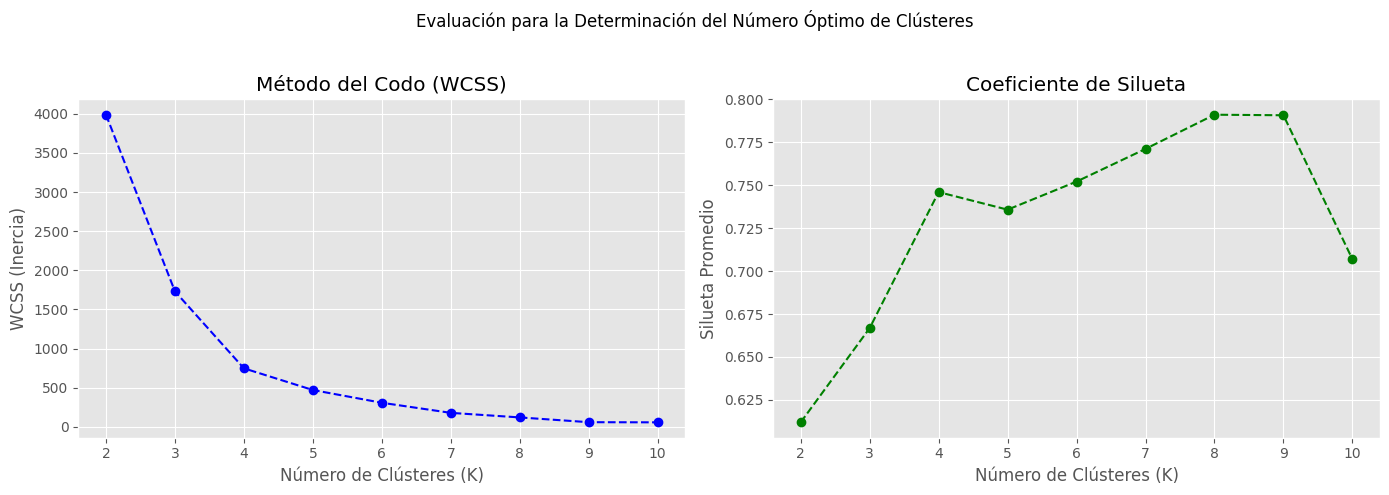


Número óptimo de clústeres (K) sugerido por Silueta: 8

--- 4. Ajustando el modelo K-Means final con K=8 ---

📍 Ubicaciones Finales de los Centros de Distribución (Centroides):
         LATITUD_CENTROIDE  LONGITUD_CENTROIDE
Cluster                                       
CD 1             -8.442973          -78.858419
CD 2            -16.409415          -71.528641
CD 3            -12.047474          -76.833115
CD 4             -3.743823          -73.228943
CD 5             -5.199497          -80.647565
CD 6            -13.536866          -71.985305
CD 7             -8.405366          -74.573549
CD 8             -6.782715          -79.849818


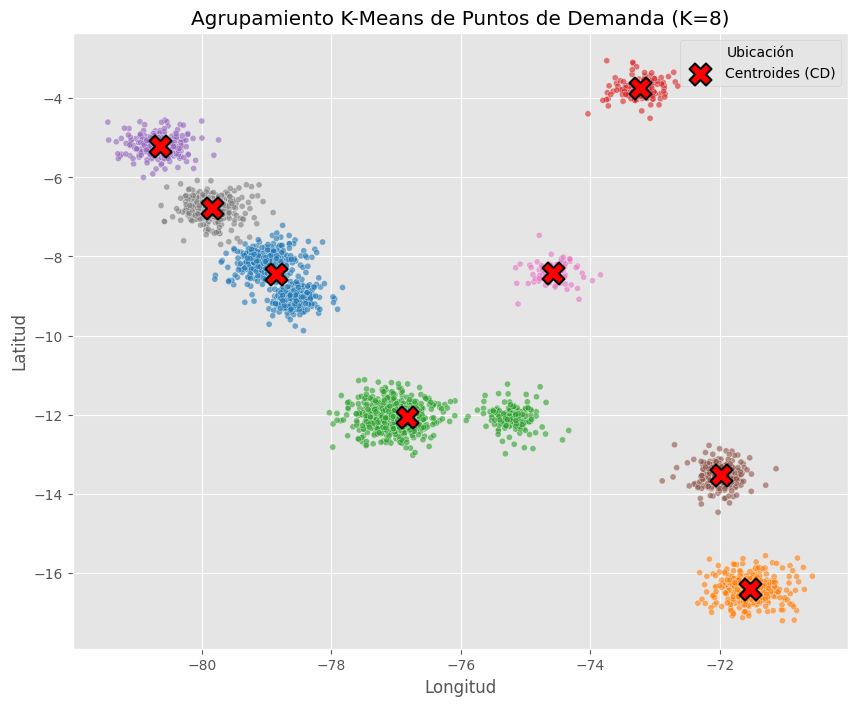

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import seaborn as sns

# URL del archivo de datos
url = "https://raw.githubusercontent.com/santiagonajera/LOCALIZACION-OPTIMA-DE-CENTROS-DE-DISTRIBUCION-MEDIANTE-MACHINE-LEARNING/main/coordenadas_peru_5000_puntos.txt"

## --- 1. Cargar y Preprocesar los Datos ---
print("--- 1. Cargando y Preprocesando Datos ---")

# CORRECCIÓN CRÍTICA: Usar sep='\t' (tabulación) para cargar el archivo
df = pd.read_csv(url, sep='\t')

# Paso 1: Limpiar los nombres de las columnas (Eliminar espacios en blanco)
df.columns = df.columns.str.strip()
print("Nombres de columnas después de la limpieza:", df.columns.tolist())

# Paso 2: Limpieza de la coma decimal (,) y conversión a tipo numérico
# Incluimos todas las columnas que contienen la coma decimal para la limpieza
numeric_cols = ['LATITUD', 'LONGITUD', 'DEMANDA_PALLETS_ANUAL', 'POBLACION_ESTIMADA', 'DENSIDAD_DEMANDA']

for col in numeric_cols:
    if col in df.columns:
        # Reemplazar la coma decimal por punto y forzar la conversión a float
        df[col] = df[col].astype(str).str.replace(',', '.', regex=False)
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Eliminar filas donde LATITUD o LONGITUD sean NaN (no pudieron convertirse)
df.dropna(subset=['LATITUD', 'LONGITUD'], inplace=True)
print(f"Número final de puntos de datos: {len(df)}")

# Seleccionar solo las características para el clustering
X = df[['LATITUD', 'LONGITUD']].copy()

# Estandarizar las coordenadas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Dimensiones de los datos para clustering: {X_scaled.shape}\n")

## --- 2. Determinar el Número Óptimo de Clústeres (K) ---
# Exploraremos un rango de K de 2 a 10
K_RANGE = range(2, 11)
wcss = []
silhouette_scores = []

print("--- 2. Calculando Métricas para diferentes K (2 a 10) ---")
for k in K_RANGE:
    # Usamos n_init='auto' para versiones recientes de scikit-learn
    kmeans_model = KMeans(n_clusters=k, init='k-means++', n_init='auto', random_state=42)
    kmeans_model.fit(X_scaled)

    # Método del Codo: Registrar la inercia (WCSS)
    wcss.append(kmeans_model.inertia_)

    # Coeficiente de Silueta
    score = silhouette_score(X_scaled, kmeans_model.labels_)
    silhouette_scores.append(score)
    print(f"K={k}: WCSS={wcss[-1]:.2f}, Silhouette Score={score:.4f}")

## --- 3. Visualización y Selección de K ---

plt.style.use('ggplot')
plt.figure(figsize=(14, 5))

# 3.1 Gráfico del Método del Codo
plt.subplot(1, 2, 1)
plt.plot(K_RANGE, wcss, marker='o', linestyle='--', color='blue')
plt.title('Método del Codo (WCSS)')
plt.xlabel('Número de Clústeres (K)')
plt.ylabel('WCSS (Inercia)')
plt.xticks(K_RANGE)


# 3.2 Gráfico del Coeficiente de Silueta
plt.subplot(1, 2, 2)
plt.plot(K_RANGE, silhouette_scores, marker='o', linestyle='--', color='green')
plt.title('Coeficiente de Silueta')
plt.xlabel('Número de Clústeres (K)')
plt.ylabel('Silueta Promedio')
plt.xticks(K_RANGE)


plt.suptitle('Evaluación para la Determinación del Número Óptimo de Clústeres')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Determinar el K óptimo basado en el Coeficiente de Silueta (el valor más alto)
optimal_k_silhouette = K_RANGE[np.argmax(silhouette_scores)]

print(f"\nNúmero óptimo de clústeres (K) sugerido por Silueta: {optimal_k_silhouette}")


## --- 4. Ajustar K-Means y Encontrar Ubicaciones (Centroides) ---

# Usa el valor sugerido o ajusta manualmente (ej. K=5, K=6, etc.) después de ver los gráficos.
FINAL_K = optimal_k_silhouette
print(f"\n--- 4. Ajustando el modelo K-Means final con K={FINAL_K} ---")

kmeans_final = KMeans(n_clusters=FINAL_K, init='k-means++', n_init='auto', random_state=42)
kmeans_final.fit(X_scaled)

# Asignar las etiquetas de clústeres al DataFrame original
df['Cluster'] = kmeans_final.labels_

# Obtener y desescalar los centroides (ubicaciones finales)
centroids_scaled = kmeans_final.cluster_centers_
# Aplicar la transformación inversa para obtener las coordenadas Lat/Lon reales
centroids = scaler.inverse_transform(centroids_scaled)

centroids_df = pd.DataFrame(centroids, columns=['LATITUD_CENTROIDE', 'LONGITUD_CENTROIDE'])
centroids_df['Cluster'] = [f'CD {i+1}' for i in range(FINAL_K)] # Renombramos a CD 1, CD 2, etc.

print("\n📍 Ubicaciones Finales de los Centros de Distribución (Centroides):")
print(centroids_df.set_index('Cluster'))


## --- 5. Visualizar los Clústeres y Centroides ---

plt.figure(figsize=(10, 8))
sns.scatterplot(x='LONGITUD', y='LATITUD', hue='Cluster', data=df,
                palette='tab10', s=20, alpha=0.6, legend=False)

# Trazar los centroides (Posibles ubicaciones de CD)
plt.scatter(centroids_df['LONGITUD_CENTROIDE'], centroids_df['LATITUD_CENTROIDE'],
            marker='X', s=250, color='red', edgecolor='black', linewidth=1.5, label='Centroides (CD)')

plt.title(f'Agrupamiento K-Means de Puntos de Demanda (K={FINAL_K})')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.legend(title='Ubicación', loc='upper right')
plt.grid(True)
plt.show()

--- 1. Cargando y Preprocesando Datos ---
Datos convertidos a radianes. Dimensiones: (5000, 2)

--- 2. Calculando Métricas (Usando métrica Haversine para Silueta) ---
K=2: WCSS=14.5260, Silhouette Score (Haversine)=0.5921
K=3: WCSS=5.8680, Silhouette Score (Haversine)=0.6683
K=4: WCSS=2.8640, Silhouette Score (Haversine)=0.7338
K=5: WCSS=1.8310, Silhouette Score (Haversine)=0.7206
K=6: WCSS=1.1724, Silhouette Score (Haversine)=0.7453
K=7: WCSS=0.6088, Silhouette Score (Haversine)=0.7803
K=8: WCSS=0.3879, Silhouette Score (Haversine)=0.8021
K=9: WCSS=0.2096, Silhouette Score (Haversine)=0.7906
K=10: WCSS=0.1443, Silhouette Score (Haversine)=0.7915


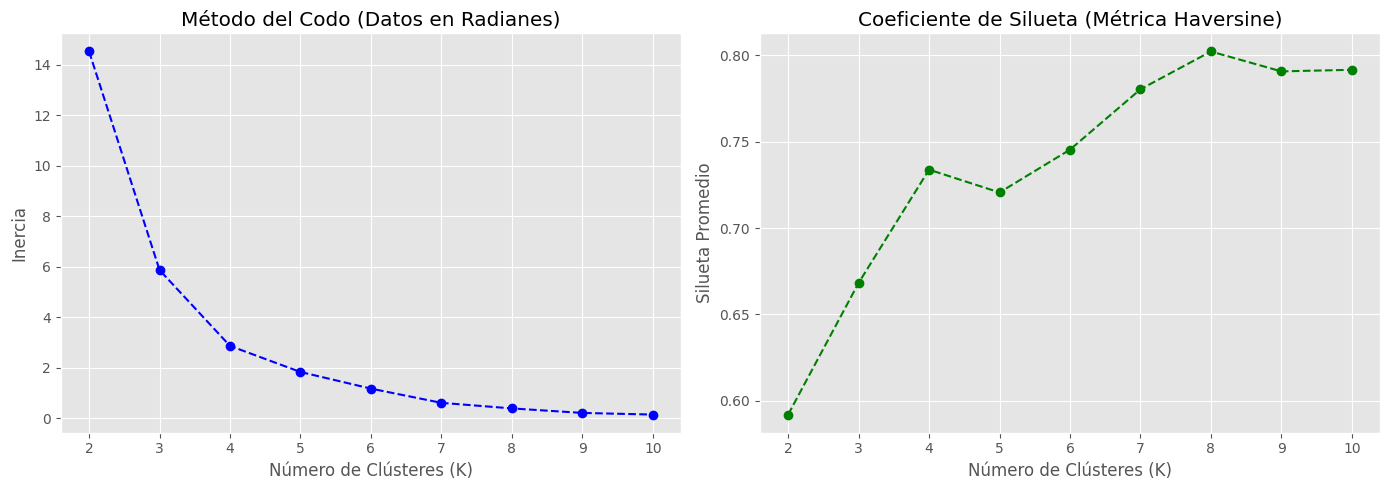


Número óptimo de clústeres sugerido (K): 8

--- 4. Generando Clústeres Finales para K=8 ---

📍 Ubicaciones Óptimas (Grados Decimales):
         LATITUD_CENTROIDE  LONGITUD_CENTROIDE
Cluster                                       
CD 1             -8.444365          -78.858539
CD 2            -16.409415          -71.528641
CD 3            -12.047474          -76.833115
CD 4             -3.743823          -73.228943
CD 5             -5.199497          -80.647565
CD 6            -13.536866          -71.985305
CD 7             -6.783524          -79.847751
CD 8             -8.405366          -74.573549


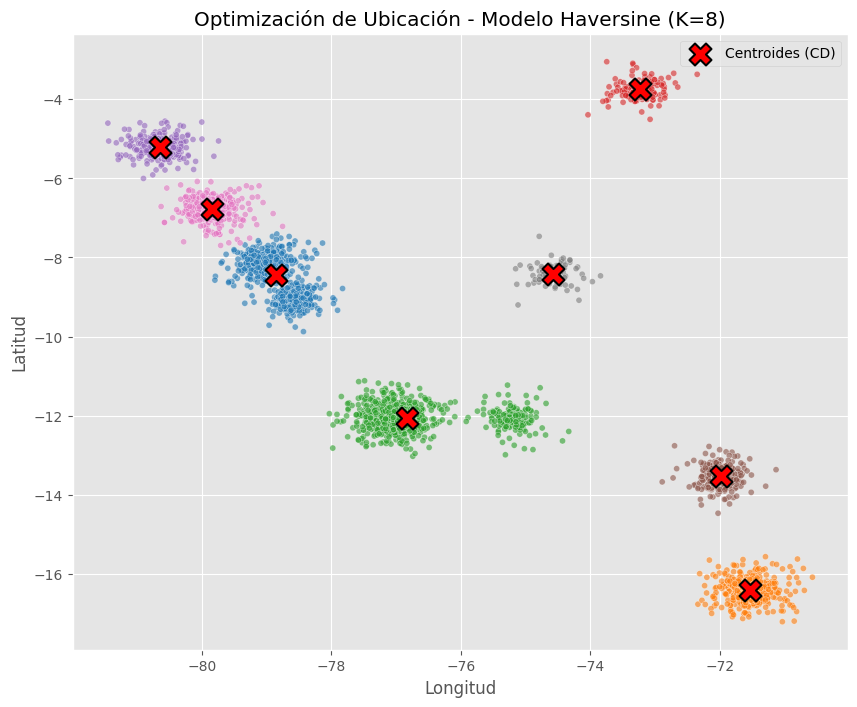

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns

# URL del archivo de datos
url = "https://raw.githubusercontent.com/santiagonajera/LOCALIZACION-OPTIMA-DE-CENTROS-DE-DISTRIBUCION-MEDIANTE-MACHINE-LEARNING/main/coordenadas_peru_5000_puntos.txt"

## --- 1. Cargar y Preprocesar los Datos ---
print("--- 1. Cargando y Preprocesando Datos ---")

# Usamos sep='\t' porque detectamos que es un archivo separado por tabulaciones
df = pd.read_csv(url, sep='\t')

# Limpieza de nombres de columnas
df.columns = df.columns.str.strip()

# Limpieza de columnas numéricas (cambiar coma por punto)
numeric_cols = ['LATITUD', 'LONGITUD']
for col in numeric_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).str.replace(',', '.', regex=False)
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Eliminar nulos
df.dropna(subset=['LATITUD', 'LONGITUD'], inplace=True)

# --- CAMBIO CLAVE: CONVERSIÓN A RADIANES ---
# Para usar lógica de distancias geográficas (Haversine), primero convertimos a radianes.
# K-Means en scikit-learn usa distancia euclidiana, pero al pasar radianes,
# la aproximación para clústeres locales es mucho más precisa geométricamente.
X_rad = np.radians(df[['LATITUD', 'LONGITUD']].copy())

print(f"Datos convertidos a radianes. Dimensiones: {X_rad.shape}\n")

## --- 2. Determinar el Número Óptimo de Clústeres (K) ---
K_RANGE = range(2, 11)
wcss = []
silhouette_scores = []

print("--- 2. Calculando Métricas (Usando métrica Haversine para Silueta) ---")
for k in K_RANGE:
    # Ajustamos K-Means sobre los datos en RADIANES
    kmeans_model = KMeans(n_clusters=k, init='k-means++', n_init='auto', random_state=42)
    kmeans_model.fit(X_rad)

    # Inercia (WCSS)
    wcss.append(kmeans_model.inertia_)

    # --- CAMBIO CLAVE: SILHOUETTE CON MÉTRICA HAVERSINE ---
    # Aquí le decimos al evaluador que calcule la cohesión usando la distancia real de la tierra
    score = silhouette_score(X_rad, kmeans_model.labels_, metric='haversine')
    silhouette_scores.append(score)
    print(f"K={k}: WCSS={wcss[-1]:.4f}, Silhouette Score (Haversine)={score:.4f}")

## --- 3. Visualización ---

plt.style.use('ggplot')
plt.figure(figsize=(14, 5))

# Gráfico del Codo
plt.subplot(1, 2, 1)
plt.plot(K_RANGE, wcss, marker='o', linestyle='--', color='blue')
plt.title('Método del Codo (Datos en Radianes)')
plt.xlabel('Número de Clústeres (K)')
plt.ylabel('Inercia')
plt.xticks(K_RANGE)

# Gráfico de Silueta
plt.subplot(1, 2, 2)
plt.plot(K_RANGE, silhouette_scores, marker='o', linestyle='--', color='green')
plt.title('Coeficiente de Silueta (Métrica Haversine)')
plt.xlabel('Número de Clústeres (K)')
plt.ylabel('Silueta Promedio')
plt.xticks(K_RANGE)

plt.tight_layout()
plt.show()

# Selección automática basada en Silueta
optimal_k = K_RANGE[np.argmax(silhouette_scores)]
print(f"\nNúmero óptimo de clústeres sugerido (K): {optimal_k}")


## --- 4. Ajuste Final y Obtención de Centroides Reales ---

print(f"\n--- 4. Generando Clústeres Finales para K={optimal_k} ---")

kmeans_final = KMeans(n_clusters=optimal_k, init='k-means++', n_init='auto', random_state=42)
kmeans_final.fit(X_rad)

# Asignar etiquetas al DF original
df['Cluster'] = kmeans_final.labels_

# Obtener centroides en Radianes
centroids_rad = kmeans_final.cluster_centers_

# --- CAMBIO CLAVE: CONVERTIR CENTROIDES DE VUELTA A GRADOS ---
# Multiplicamos por 180/pi (np.degrees) para tener Lat/Lon legibles
centroids_deg = np.degrees(centroids_rad)

centroids_df = pd.DataFrame(centroids_deg, columns=['LATITUD_CENTROIDE', 'LONGITUD_CENTROIDE'])
centroids_df['Cluster'] = [f'CD {i+1}' for i in range(optimal_k)]

print("\n📍 Ubicaciones Óptimas (Grados Decimales):")
print(centroids_df.set_index('Cluster'))

## --- 5. Visualización Final en el Mapa ---

plt.figure(figsize=(10, 8))
# Puntos de demanda
sns.scatterplot(x='LONGITUD', y='LATITUD', hue='Cluster', data=df,
                palette='tab10', s=20, alpha=0.6, legend=False)

# Centroides
plt.scatter(centroids_df['LONGITUD_CENTROIDE'], centroids_df['LATITUD_CENTROIDE'],
            marker='X', s=250, color='red', edgecolor='black', linewidth=1.5, label='Centroides (CD)')

plt.title(f'Optimización de Ubicación - Modelo Haversine (K={optimal_k})')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.legend()
plt.grid(True)
plt.show()

--- 1. Carga y Limpieza Inicial ---


/tmp/ipython-input-779656181.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['DEMANDA_PALLETS_ANUAL'].fillna(df['DEMANDA_PALLETS_ANUAL'].mean(), inplace=True)
/tmp/ipython-input-779656181.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].

Datos limpios: 5000 registros.

--- 2. Transformación de Variables (Nominales y Numéricas) ---
Matriz final para Clustering: (5000, 11)
Variables utilizadas (ejemplo): ['LATITUD', 'LONGITUD', 'DEMANDA_PALLETS_ANUAL', 'POBLACION_ESTIMADA', 'SCORE_ABC', 'ZONA_GEOGRAFICA_Costa', 'ZONA_GEOGRAFICA_Selva'] ...

--- 3. Evaluando número de clústeres (Multivariado) ---
K=2: Silhouette=0.4303
K=3: Silhouette=0.4672
K=4: Silhouette=0.4806
K=5: Silhouette=0.4761
K=6: Silhouette=0.5209
K=7: Silhouette=0.4768
K=8: Silhouette=0.5092
K=9: Silhouette=0.5372
K=10: Silhouette=0.5369


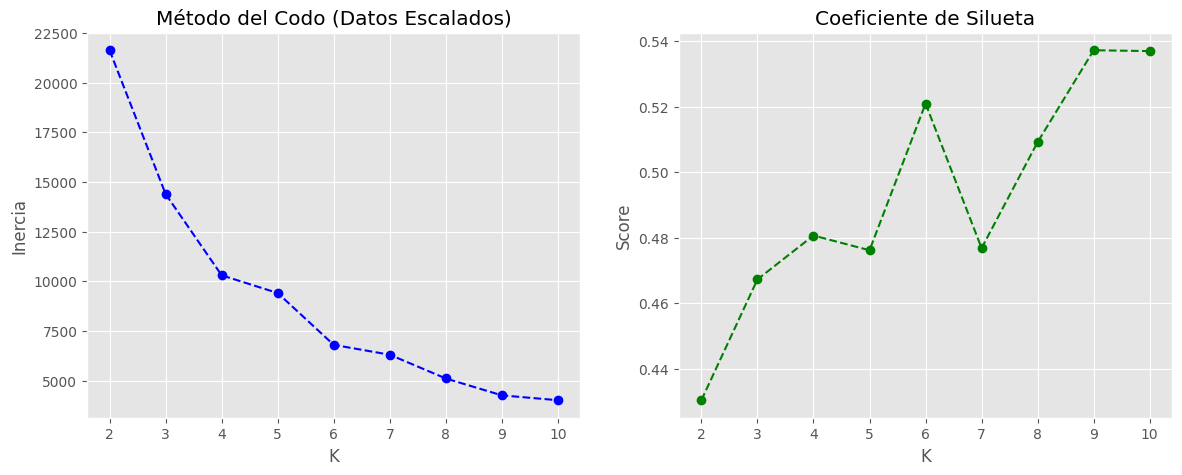


K sugerido por Silueta: 9

--- 4. Ejecutando K-Means con K=9 ---

📊 Perfil de los Clústeres (Promedios):
         DEMANDA_PALLETS_ANUAL  POBLACION_ESTIMADA  SCORE_ABC
Cluster                                                      
0                   333.515326         3843.130268   1.000000
1                   311.964072         3657.419162   1.000000
2                  7069.805085        80736.152542   2.983051
3                  2170.572491        25099.631970   2.011152
4                  2085.744337        24111.935275   2.000000
5                   313.784463         3599.038842   1.000000
6                   317.077406         3600.369247   1.000000
7                 13871.500000       172580.500000   3.000000
8                  2052.368827        23662.967593   2.000000

📍 Ubicaciones Geográficas Sugeridas:
   Cluster  LATITUD_CENTROIDE  LONGITUD_CENTROIDE
0        0          -8.562709          -78.832226
1        1         -15.448444          -71.687671
2        2         -10.3

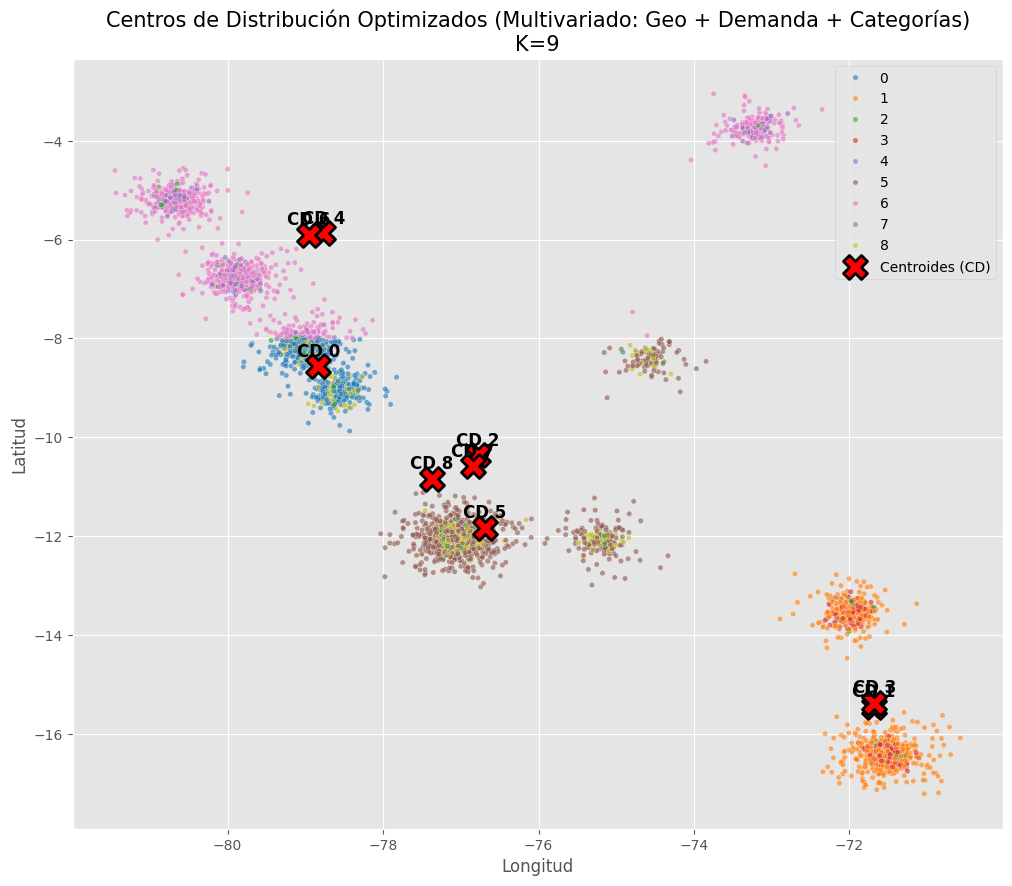

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import silhouette_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# URL del archivo de datos
url = "https://raw.githubusercontent.com/santiagonajera/LOCALIZACION-OPTIMA-DE-CENTROS-DE-DISTRIBUCION-MEDIANTE-MACHINE-LEARNING/main/coordenadas_peru_5000_puntos.txt"

print("--- 1. Carga y Limpieza Inicial ---")
df = pd.read_csv(url, sep='\t')
df.columns = df.columns.str.strip()

# Limpieza de decimales (coma por punto) en variables numéricas
cols_decimales = ['LATITUD', 'LONGITUD', 'DEMANDA_PALLETS_ANUAL', 'POBLACION_ESTIMADA', 'DENSIDAD_DEMANDA']
for col in cols_decimales:
    if col in df.columns:
        df[col] = df[col].astype(str).str.replace(',', '.', regex=False)
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Eliminar filas sin coordenadas
df.dropna(subset=['LATITUD', 'LONGITUD'], inplace=True)

# Rellenar nulos en otras variables numéricas con la media (para no perder datos)
df['DEMANDA_PALLETS_ANUAL'].fillna(df['DEMANDA_PALLETS_ANUAL'].mean(), inplace=True)
df['POBLACION_ESTIMADA'].fillna(df['POBLACION_ESTIMADA'].mean(), inplace=True)

print(f"Datos limpios: {len(df)} registros.")

## --- 2. Ingeniería de Características (Feature Engineering) ---
print("\n--- 2. Transformación de Variables (Nominales y Numéricas) ---")

# A) Mapeo Manual de Variables Ordinales (Donde el orden importa)
# Asumimos que A > B > C, por lo tanto damos pesos numéricos
mapa_abc = {'A': 3, 'B': 2, 'C': 1}
# Si hay valores que no sean A,B,C, los llenamos con 1 (C)
df['SCORE_ABC'] = df['CLASIFICACION_ABC'].map(mapa_abc).fillna(1)

# B) Selección de Variables para el Modelo
# No usamos 'LOCALIDAD' (es un ID). Usamos Lat/Lon + Demanda + Poblacion + Score ABC + Region/Zona
features_numericas = ['LATITUD', 'LONGITUD', 'DEMANDA_PALLETS_ANUAL', 'POBLACION_ESTIMADA', 'SCORE_ABC']
features_categoricas = ['ZONA_GEOGRAFICA', 'REGION'] # Variables nominales puras

# C) Pipeline de Preprocesamiento
# - Numéricas: StandardScaler (Media 0, Desviación 1) para quitar el peso de las unidades extremas
# - Categóricas: OneHotEncoder (Crea columnas binarias: Region_Cusco=1, Region_Lima=0...)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features_numericas),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), features_categoricas)
    ]
)

# Aplicar transformaciones
X_procesado = preprocessor.fit_transform(df)

# Obtener nombres de las columnas generadas (útil para entender qué pasó)
feature_names_out = (features_numericas +
                     list(preprocessor.named_transformers_['cat'].get_feature_names_out(features_categoricas)))

print(f"Matriz final para Clustering: {X_procesado.shape}")
print(f"Variables utilizadas (ejemplo): {feature_names_out[:7]} ...")


## --- 3. Determinación de K (Elbow & Silhouette) ---

K_RANGE = range(2, 11)
wcss = []
silhouette_scores = []

print("\n--- 3. Evaluando número de clústeres (Multivariado) ---")
for k in K_RANGE:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init='auto', random_state=42)
    kmeans.fit(X_procesado)

    wcss.append(kmeans.inertia_)
    score = silhouette_score(X_procesado, kmeans.labels_)
    silhouette_scores.append(score)
    print(f"K={k}: Silhouette={score:.4f}")

# Gráficos
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(K_RANGE, wcss, 'bo--')
plt.title('Método del Codo (Datos Escalados)')
plt.xlabel('K')
plt.ylabel('Inercia')

plt.subplot(1, 2, 2)
plt.plot(K_RANGE, silhouette_scores, 'go--')
plt.title('Coeficiente de Silueta')
plt.xlabel('K')
plt.ylabel('Score')
plt.show()

optimal_k = K_RANGE[np.argmax(silhouette_scores)]
print(f"\nK sugerido por Silueta: {optimal_k}")


## --- 4. Clustering Final y Ubicación de Centroides ---

FINAL_K = optimal_k # O cámbialo manualmente si el gráfico del codo sugiere otro
print(f"\n--- 4. Ejecutando K-Means con K={FINAL_K} ---")

kmeans_final = KMeans(n_clusters=FINAL_K, init='k-means++', n_init='auto', random_state=42)
kmeans_final.fit(X_procesado)

# Asignar clúster al DF original
df['Cluster'] = kmeans_final.labels_

# CALCULAR CENTROIDES GEOGRÁFICOS REALES
# Nota: Aunque el clustering usó todas las variables (demanda, región, etc.),
# el centroide físico (donde pones el almacén) es el promedio de Lat/Lon de los puntos del clúster.
centroides_geo = df.groupby('Cluster')[['LATITUD', 'LONGITUD']].mean().reset_index()
centroides_geo.rename(columns={'LATITUD': 'LATITUD_CENTROIDE', 'LONGITUD': 'LONGITUD_CENTROIDE'}, inplace=True)

# Análisis de los Clústeres (Perfilamiento)
# Veamos qué caracteriza a cada clúster (promedios de demanda y población)
perfil_cluster = df.groupby('Cluster')[['DEMANDA_PALLETS_ANUAL', 'POBLACION_ESTIMADA', 'SCORE_ABC']].mean()
print("\n📊 Perfil de los Clústeres (Promedios):")
print(perfil_cluster)
print("\n📍 Ubicaciones Geográficas Sugeridas:")
print(centroides_geo)


## --- 5. Visualización Avanzada ---

plt.figure(figsize=(12, 10))

# Puntos coloreados por Clúster
sns.scatterplot(data=df, x='LONGITUD', y='LATITUD', hue='Cluster', palette='tab10', s=15, alpha=0.6)

# Centroides
plt.scatter(centroides_geo['LONGITUD_CENTROIDE'], centroides_geo['LATITUD_CENTROIDE'],
            s=300, c='red', marker='X', edgecolors='black', linewidth=2, label='Centroides (CD)')

# Etiquetas de texto para los centroides
for i, row in centroides_geo.iterrows():
    plt.text(row['LONGITUD_CENTROIDE'], row['LATITUD_CENTROIDE'] + 0.2,
             f"CD {int(row['Cluster'])}", fontsize=12, fontweight='bold', color='black', ha='center')

plt.title(f'Centros de Distribución Optimizados (Multivariado: Geo + Demanda + Categorías)\nK={FINAL_K}', fontsize=15)
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.legend()
plt.grid(True)
plt.show()